In [85]:
import numpy as np
from pathlib import Path
import cmath
import sys
import os
import importlib
import pandas as pd
import matplotlib.pyplot as plt
import multiprocess as mp
from functools import partial

sys.path.insert(0, os.path.abspath('../src'))
from modeling_cascading_failure import simulate
importlib.reload(simulate)

nprect = np.vectorize(cmath.rect)
npphase = np.vectorize(cmath.phase)
def convert_complex(x):
    return complex(x.replace("i","j"))
npconvert = np.vectorize(convert_complex)

plots_path = Path("./plots")

# prepare inputs

num_buses = 14
eps=0.0001
max_iter=100

# get data
Y = np.loadtxt(Path("./data") / "Y{}.csv".format(num_buses),
                 delimiter=",", dtype=str)
Y = npconvert(Y)
v = np.loadtxt(Path("./data") / "v{}.csv".format(num_buses),
                 delimiter=",", dtype=str)
v = npconvert(v)
slack = np.loadtxt(Path("./data") / "slack{}.csv".format(num_buses),
                 delimiter=",", dtype=str)
slack = int(slack) - 1
s = np.loadtxt(Path("./data") / "s{}.csv".format(num_buses),
                 delimiter=",", dtype=str)
s = npconvert(s)
pv = np.loadtxt(Path("./data") / "pv{}.csv".format(num_buses),
                 delimiter=",", dtype=str)
pv = pv.astype(int) - 1
pq = np.loadtxt(Path("./data") / "pq{}.csv".format(num_buses),
                 delimiter=",", dtype=str)
pq = pq.astype(int) - 1
base_mva = np.loadtxt(Path("./data") / "base_mva{}.csv".format(num_buses),
                 delimiter=",", dtype=str)
base_mva = float(base_mva)

# convert data
PV_x = np.array([1 if i in pv else 0 for i in range(Y.shape[0])]).reshape(-1,1)
PQ_x = np.array([1 if i in pq else 0 for i in range(Y.shape[0])]).reshape(-1,1)
x_slack = np.array([1 if i==slack else 0 for i in range(Y.shape[0])]).reshape(-1,1)
V_abs_full = abs(v).reshape(-1,1)
V_phase_full = npphase(v).reshape(-1,1)
P_full = np.real(s).reshape(-1,1)
Q_full = np.imag(s).reshape(-1,1)

# prepare inputs
V_abs = np.copy(V_abs_full)
V_abs[PQ_x==1] = 1

V_phase = np.copy(V_phase_full)
V_phase[x_slack==0] = 0

P_input = np.copy(P_full)
P_input[x_slack==1] = np.nan

Q_input = np.copy(Q_full)
Q_input[PQ_x==0] = np.nan


# Define the simulation function for multiprocessing
def multiprocess_simulation(alpha, args_before_alpha, args_after_alpha):
    args = args_before_alpha + (alpha,) + args_after_alpha
    (
        _,_,_,_,_,_,_,_,_,fraction_lines_failed,fraction_lines_failed_static,fraction_nodes_disconnected
    )=simulate.simulate_system(*args)

    results_alpha = pd.DataFrame(data=dict(
        alpha=alpha,
        fraction_lines_failed=[fraction_lines_failed],
        fraction_lines_failed_static=[fraction_lines_failed_static],
        fraction_nodes_disconnected=[fraction_nodes_disconnected]
    )).set_index("alpha")

    return results_alpha

def make_plots(case_name,run_all_alphas=False):
    global Y, PV_x, PQ_x, x_slack, V_abs, V_phase, P_input, Q_input, eps, max_iter, base_mva, lines_to_cut
    global nodes_to_cut, alpha, frequency_deviation_threshold, apply_freq_dev_during_sim, I, H, gamma, t_max
    global include_resistive_losses, alpha_min, alpha_max, n_alpha, node_freq_plot
    
    (
        theta,
        omega,
        F,
        P,
        line_failures,
        node_failures,
        F_threshold,
        line_failures_static,
        flows_static,
        fraction_lines_failed,
        fraction_lines_failed_static,
        fraction_nodes_disconnected
    )=simulate.simulate_system(
        Y,
        PV_x,
        PQ_x,
        x_slack,
        V_abs,
        V_phase,
        P_input,
        Q_input,
        eps,
        max_iter,
        base_MVA=base_mva,
        lines_to_cut=lines_to_cut,
        nodes_to_cut=nodes_to_cut,
        cut_time=1,
        delta_t=0.1,
        alpha=alpha,
        frequency_deviation_threshold=frequency_deviation_threshold,
        apply_freq_dev_during_sim=apply_freq_dev_during_sim,
        I=I,
        H=H,
        gamma=gamma,
        t_max=t_max,
        include_resistive_losses=include_resistive_losses,
        ref_freq=60
    )

    # dynamic case
    lines = np.argwhere(np.abs(F.sel(time=0).values)>0)
    lines = list(set([tuple(sorted(line)) for line in lines]))
    fig,ax=plt.subplots()
    for line in lines:
        data= F.sel(node_i=line[0],node_j=line[1])
        plt.plot(data.time,data.values,label="{}_{}".format(line[0],line[1]))
        if H is None:
            plt.title("I={},$\gamma$={}".format(I_val,gamma_val))
        else:
            plt.title("H={},$\gamma$={}".format(H,gamma_val))
        plt.legend(loc=(1.01,0))
        plt.savefig(plots_path / "{}_dynamic.png".format(case_name),dpi=300,bbox_inches="tight")

    # static case
    lines = np.argwhere(np.abs(flows_static.sel(iteration=0).values)>0)
    lines = list(set([tuple(sorted(line)) for line in lines]))
    fig,ax=plt.subplots()
    for line in lines:
        data= flows_static.sel(node_i=line[0],node_j=line[1])
        iterations = list(data.iteration) + [t_max]
        values = list(data.values) + [data.values[-1]]
        plt.step(iterations,values,label="{}_{}".format(line[0],line[1]),where="post")
        plt.title("Static case")
        plt.legend(loc=(1.01,0))
        plt.savefig(plots_path / "{}_static.png".format(case_name),dpi=300,bbox_inches="tight")


    # plot frequency
    fig,ax=plt.subplots()
    omega_hz = (omega.sel(node=node_freq_plot) / (2*np.pi)) + 60
    omega_hz.plot(ax=ax)
    plt.title("Frequency at node {}".format(node_freq_plot))
    plt.savefig(plots_path / "{}_frequency.png".format(case_name),dpi=300,bbox_inches="tight")
    
    if run_all_alphas:
    
        # Prepare the inputs
        args_before_alpha = (Y, PV_x, PQ_x, x_slack, V_abs, V_phase, P_input, Q_input, eps, max_iter, base_mva,
                             lines_to_cut, nodes_to_cut, 1, 0.1)
        args_after_alpha = (frequency_deviation_threshold, apply_freq_dev_during_sim, I, H, gamma, 10,
                            include_resistive_losses, 60)
        alphas = np.linspace(alpha_min,alpha_max,n_alpha)

        # Use a pool of workers
        print("running parallel simulation")
        with mp.Pool(processes=mp.cpu_count()) as pool:
            partial_func = partial(multiprocess_simulation, args_before_alpha=args_before_alpha, args_after_alpha=args_after_alpha)
            list_results = pool.map(partial_func, alphas)
        print("finished parallel simulation")
        # Combine the results
        results = pd.concat(list_results, axis=0)

        fig,ax=plt.subplots()
        plt.plot(results.index,results.fraction_lines_failed,label="Fraction lines failed in dynamic case")
        plt.plot(results.index,results.fraction_lines_failed_static,label="Fraction lines failed in static case")
        plt.plot(results.index,results.fraction_nodes_disconnected,label="Fraction nodes disconnected in dynamic case")
        plt.legend()
        plt.xlabel("Threshold alpha")
        plt.ylabel("Fraction lines or nodes failed")
        plt.title("Comparison of failures in static and dynamic cases")
        plt.savefig(plots_path / "{}_alpha_{}_to_{}.png".format(case_name,alpha_min,alpha_max),dpi=300,bbox_inches="tight")

running parallel simulation
Note N-R after cut could not solve due to error Singular matrix
reached maximum N-R iterations, aborting static solve
reached maximum N-R iterations, aborting static solve
reached maximum N-R iterations, aborting static solve
reached maximum N-R iterations, aborting static solve
finished parallel simulation


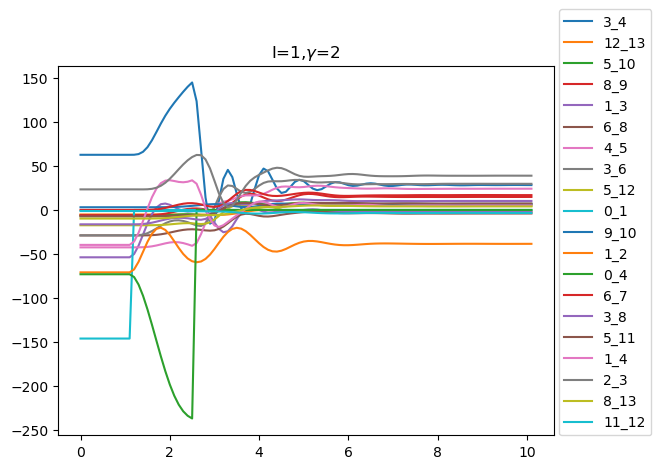

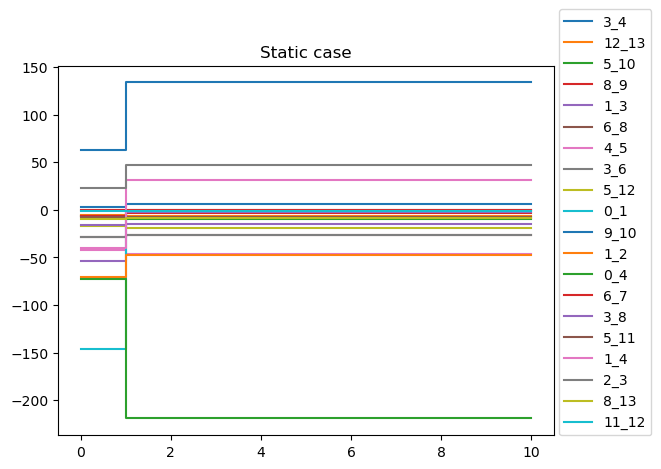

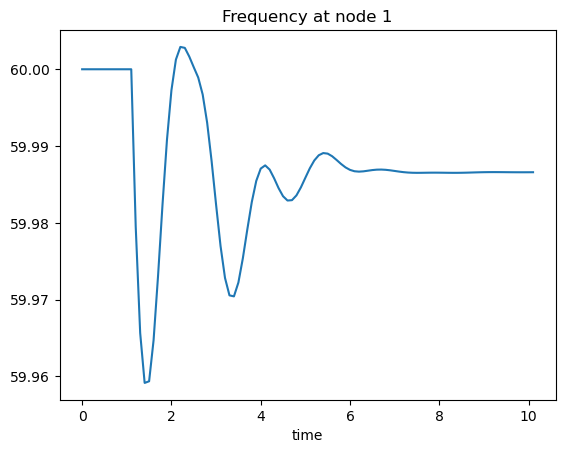

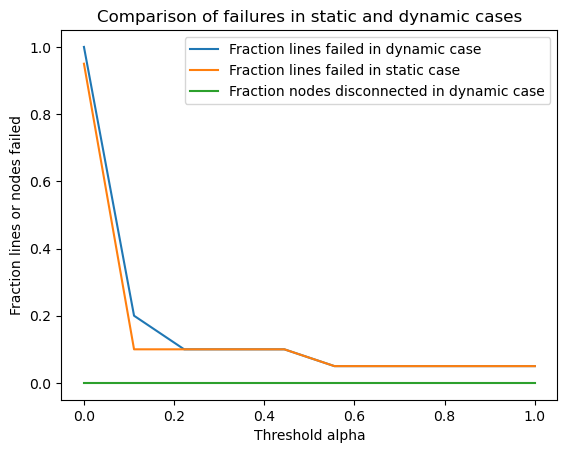

In [86]:
# base case
lines_to_cut=[(0,1)]
nodes_to_cut=None
alpha=0.5
I_val = 1
gamma_val=2
I=np.ones(num_buses).reshape(-1,1)*I_val
H=None
gamma = np.ones(num_buses).reshape(-1,1)*gamma_val
frequency_deviation_threshold=0.6
apply_freq_dev_during_sim=False
include_resistive_losses=False
t_max=10
alpha_min=0
alpha_max=1
n_alpha=10
node_freq_plot=1
case_name="base_cut01_alpha0.5_I1_gamma2_noresist_no_freqdev"

make_plots(case_name,run_all_alphas=True)

[[0.05809156]
 [0.00485423]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]]
running parallel simulation
[[0.05809156]
 [0.00485423]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]][[0.05809156]
 [0.00485423]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]][[0.05809156]
 [0.00485423]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]]


[[0.05809156]
 [0.00485423]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [

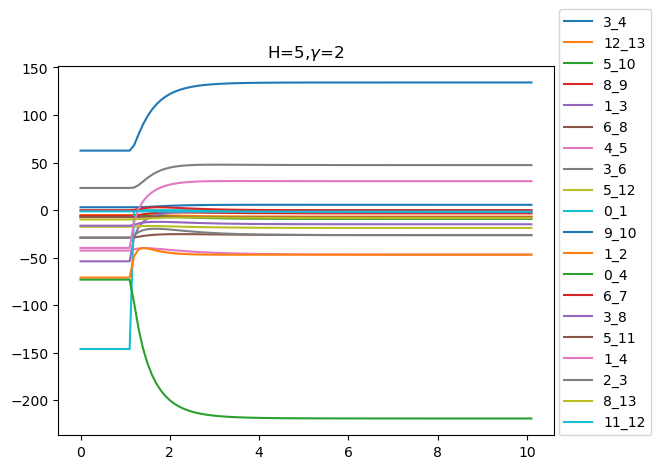

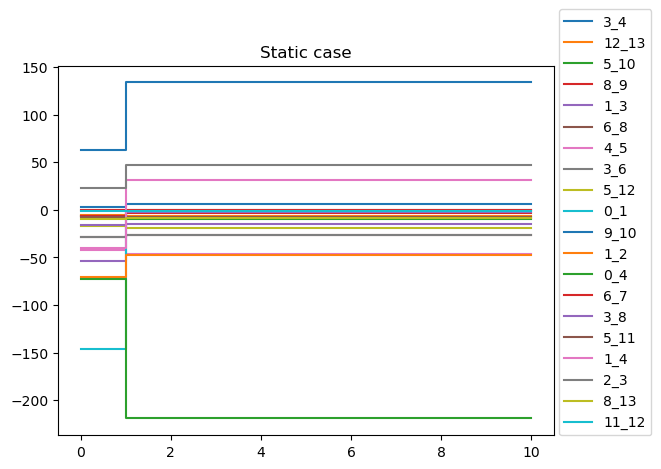

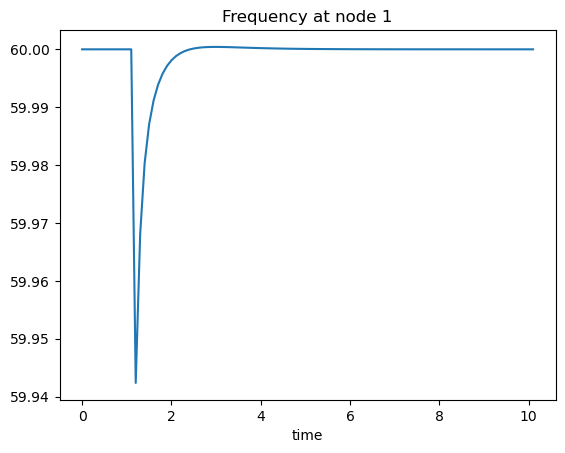

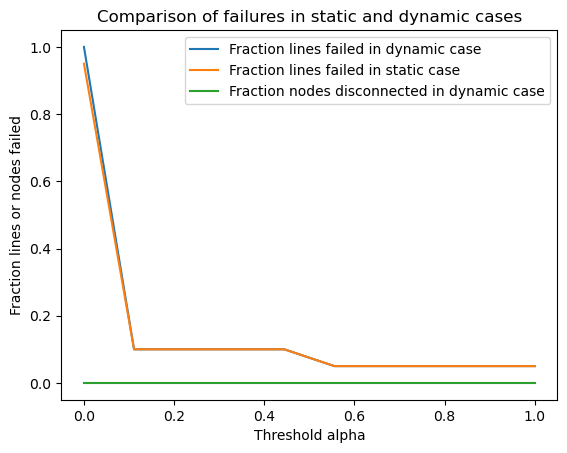

In [88]:
# with more realistic I
lines_to_cut=[(0,1)]
nodes_to_cut=None
alpha=0.5
I_val = 1
gamma_val=2
I=None#np.ones(num_buses).reshape(-1,1)*I_val
H=5
gamma = np.ones(num_buses).reshape(-1,1)*gamma_val
frequency_deviation_threshold=0.6
apply_freq_dev_during_sim=False
include_resistive_losses=False
t_max=10
alpha_min=0
alpha_max=1
n_alpha=10
node_freq_plot=1
case_name="realisticI_cut01_alpha0.5_H5_gamma2_noresist_no_freqdev"

make_plots(case_name,run_all_alphas=True)

running parallel simulation
Note N-R after cut could not solve due to error Singular matrix
reached maximum N-R iterations, aborting static solve
reached maximum N-R iterations, aborting static solve
reached maximum N-R iterations, aborting static solve
reached maximum N-R iterations, aborting static solve
finished parallel simulation


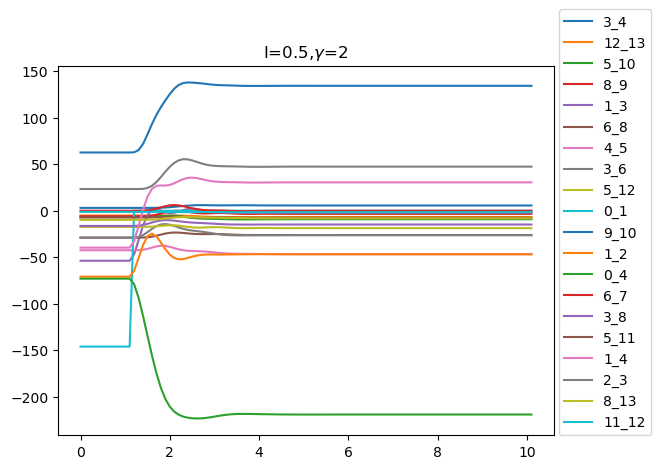

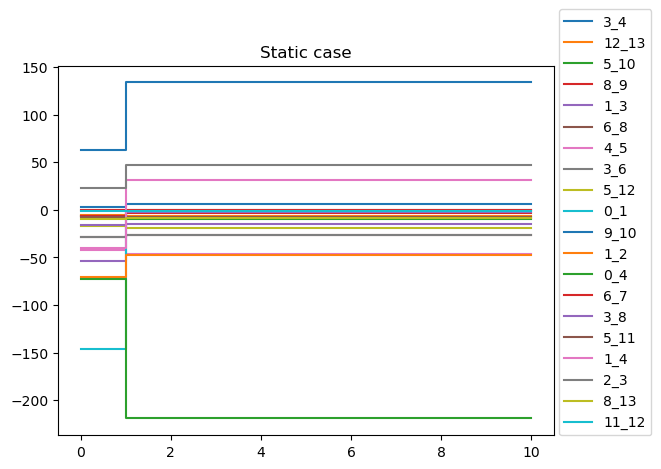

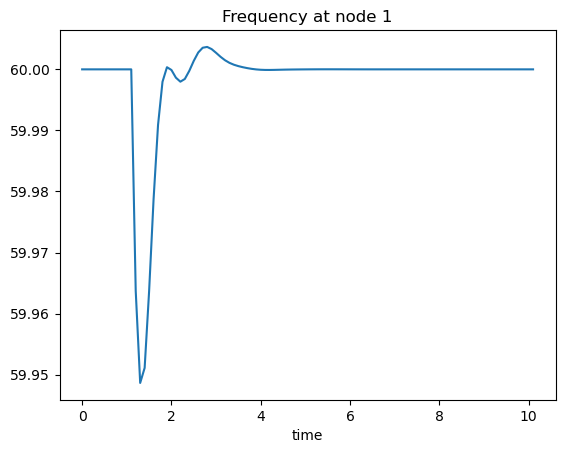

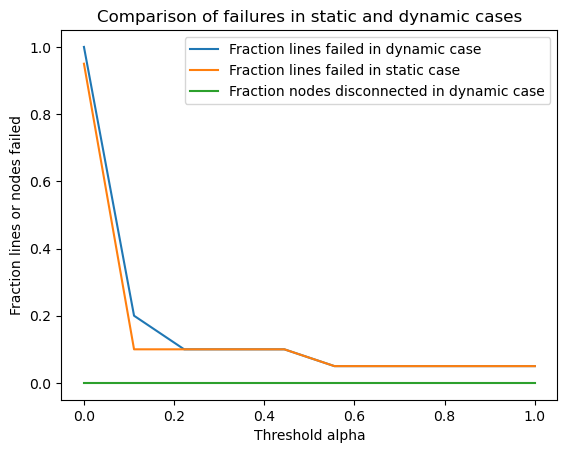

In [89]:
# impact of lower inertia across the board
lines_to_cut=[(0,1)]
nodes_to_cut=None
alpha=0.5
I_val = 0.5
gamma_val=2
I=np.ones(num_buses).reshape(-1,1)*I_val
H=None
gamma = np.ones(num_buses).reshape(-1,1)*gamma_val
frequency_deviation_threshold=0.6
apply_freq_dev_during_sim=False
include_resistive_losses=False
t_max=10
alpha_min=0
alpha_max=1
n_alpha=10
node_freq_plot=1
case_name="lowerI_cut01_alpha0.5_I0.5_gamma2_noresist_no_freqdev"

make_plots(case_name,run_all_alphas=True)

running parallel simulation
Note N-R after cut could not solve due to error Singular matrix
reached maximum N-R iterations, aborting static solve
reached maximum N-R iterations, aborting static solve
reached maximum N-R iterations, aborting static solve
reached maximum N-R iterations, aborting static solve
finished parallel simulation


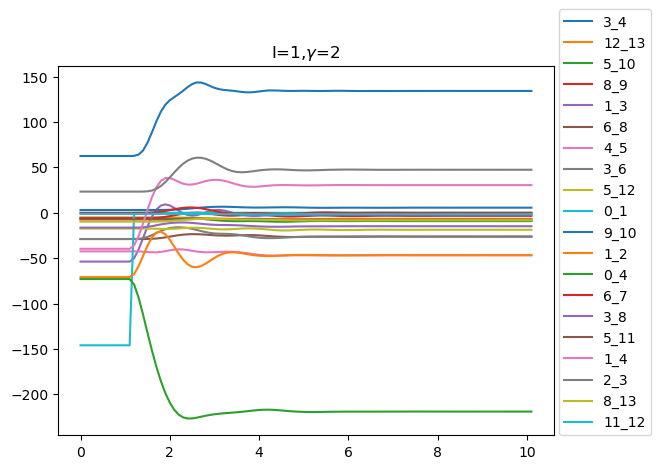

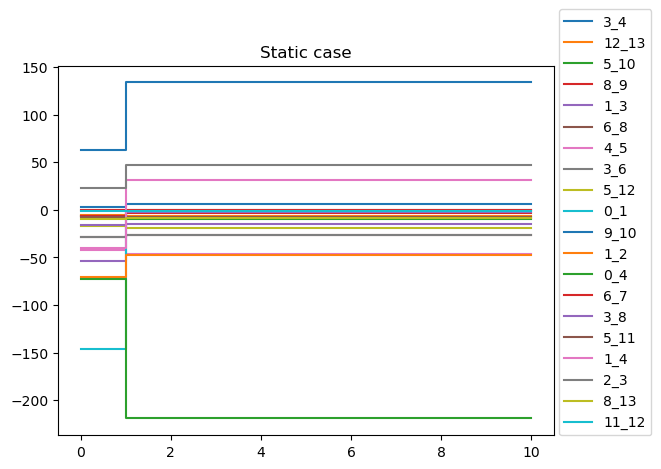

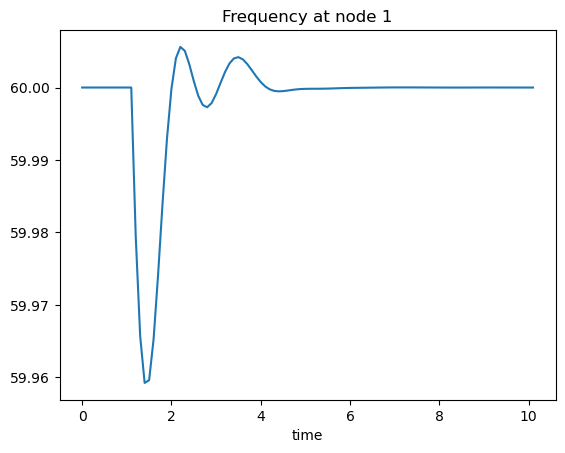

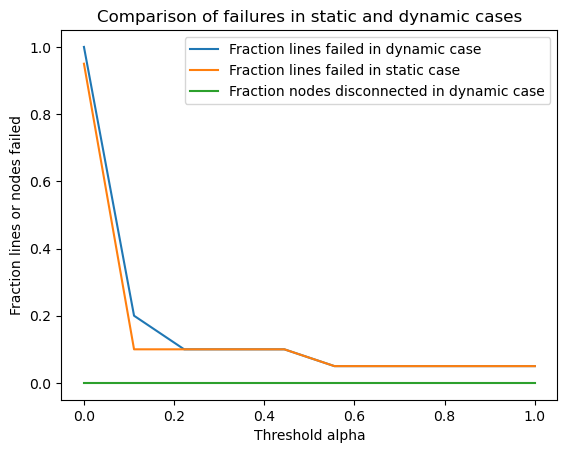

In [90]:
# impact of lower inertia just for largest generator
lines_to_cut=[(0,1)]
nodes_to_cut=None
alpha=0.5
I_val = 1
gamma_val=2
I=np.ones(num_buses).reshape(-1,1)*I_val
I[0,0] = 0.5
H=None
gamma = np.ones(num_buses).reshape(-1,1)*gamma_val
frequency_deviation_threshold=0.6
apply_freq_dev_during_sim=False
include_resistive_losses=False
t_max=10
alpha_min=0
alpha_max=1
n_alpha=10
node_freq_plot=1
case_name="lower_I_largest_generator_cut01_alpha0.5_I0.5_gamma2_noresist_no_freqdev"

make_plots(case_name,run_all_alphas=True)

reached maximum N-R iterations, aborting static solve
running parallel simulation
reached maximum N-R iterations, aborting static solve
reached maximum N-R iterations, aborting static solve
reached maximum N-R iterations, aborting static solve
reached maximum N-R iterations, aborting static solve
reached maximum N-R iterations, aborting static solve
reached maximum N-R iterations, aborting static solve
reached maximum N-R iterations, aborting static solve
reached maximum N-R iterations, aborting static solve
reached maximum N-R iterations, aborting static solve
reached maximum N-R iterations, aborting static solve
finished parallel simulation


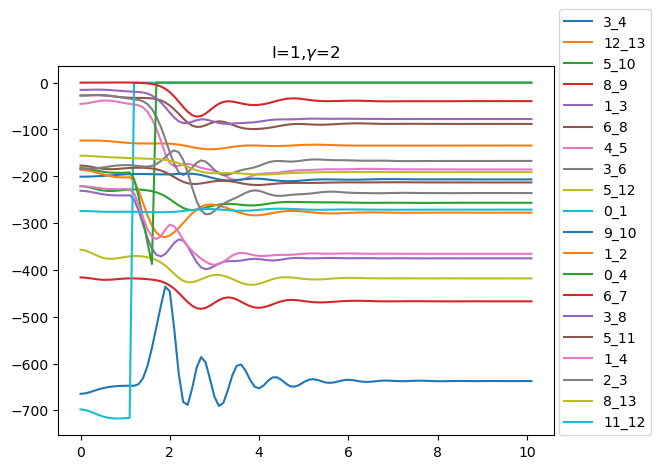

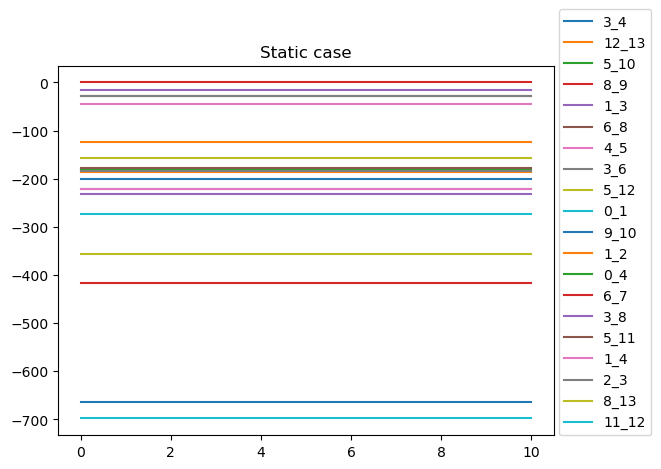

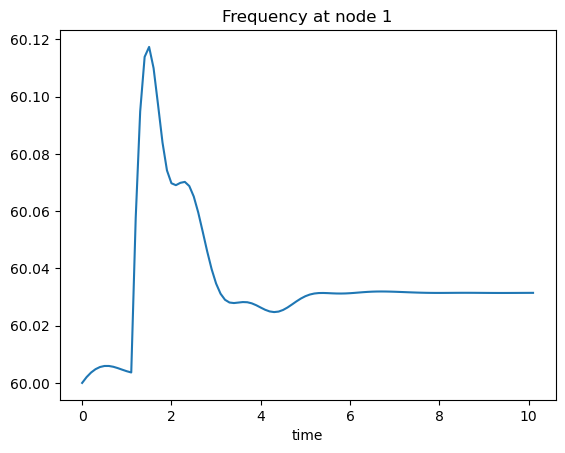

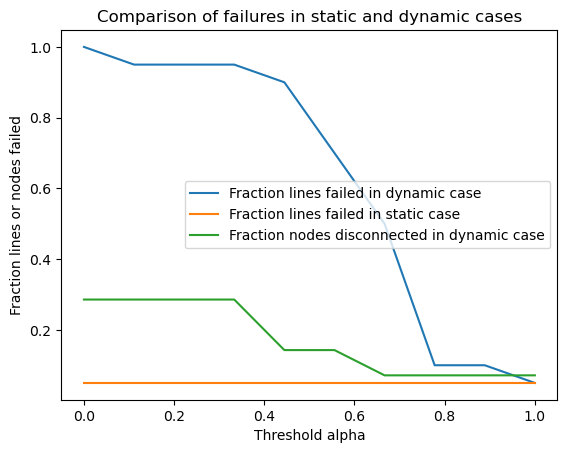

In [91]:
# impact of adding resistive losses with same I
lines_to_cut=[(0,1)]
nodes_to_cut=None
alpha=0.8
I_val = 1
gamma_val=2
I=np.ones(num_buses).reshape(-1,1)*I_val
H=None
gamma = np.ones(num_buses).reshape(-1,1)*gamma_val
frequency_deviation_threshold=0.6
apply_freq_dev_during_sim=False
include_resistive_losses=True
t_max=10
alpha_min=0
alpha_max=1
n_alpha=10
node_freq_plot=1
case_name="addG_cut01_alpha0.8_I1_gamma2_withresist_no_freqdev"

make_plots(case_name,run_all_alphas=True)

[[0.06168779]
 [0.00485423]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]]
reached maximum N-R iterations, aborting static solve
running parallel simulation
[[0.06168779]
 [0.00485423]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]]
[[0.06168779]
 [0.00485423]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]]
[[0.06168779]
 [0.00485423]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]][[0.06168779]
 [0.00485423]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.0

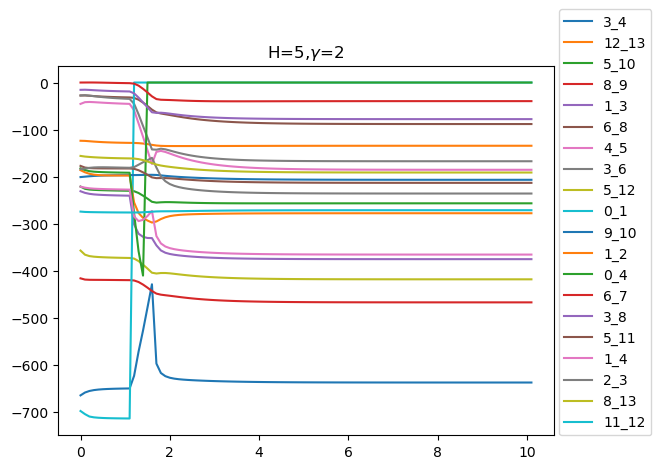

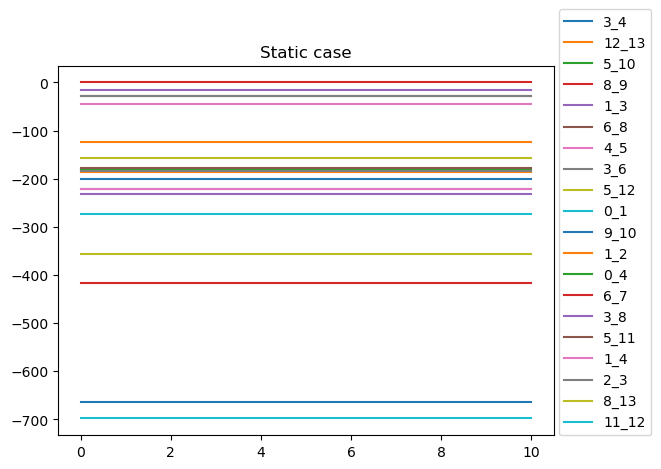

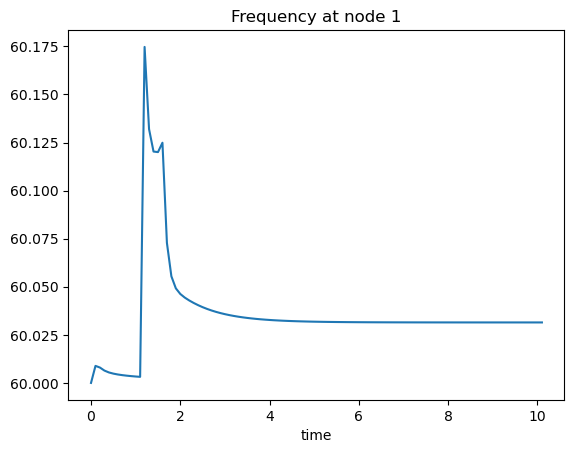

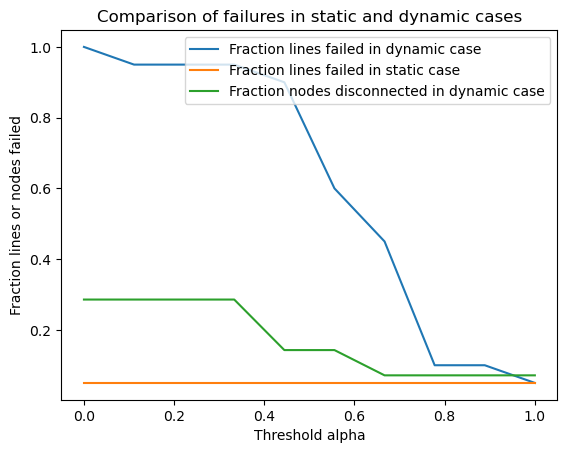

In [92]:
# impact of adding resistive losses with realistic I
lines_to_cut=[(0,1)]
nodes_to_cut=None
alpha=0.8
I_val = 1
gamma_val=2
I=None#np.ones(num_buses).reshape(-1,1)*I_val
H=5
gamma = np.ones(num_buses).reshape(-1,1)*gamma_val
frequency_deviation_threshold=0.6
apply_freq_dev_during_sim=False
include_resistive_losses=True
t_max=10
alpha_min=0
alpha_max=1
n_alpha=10
node_freq_plot=1
case_name="addG_realisticI_cut01_alpha0.8_H5_gamma2_withresist_no_freqdev"

make_plots(case_name,run_all_alphas=True)

reached maximum N-R iterations, aborting static solve
running parallel simulation
reached maximum N-R iterations, aborting static solve
reached maximum N-R iterations, aborting static solve
reached maximum N-R iterations, aborting static solve
reached maximum N-R iterations, aborting static solve
reached maximum N-R iterations, aborting static solve
reached maximum N-R iterations, aborting static solve
reached maximum N-R iterations, aborting static solve
reached maximum N-R iterations, aborting static solve
reached maximum N-R iterations, aborting static solve
reached maximum N-R iterations, aborting static solve
finished parallel simulation


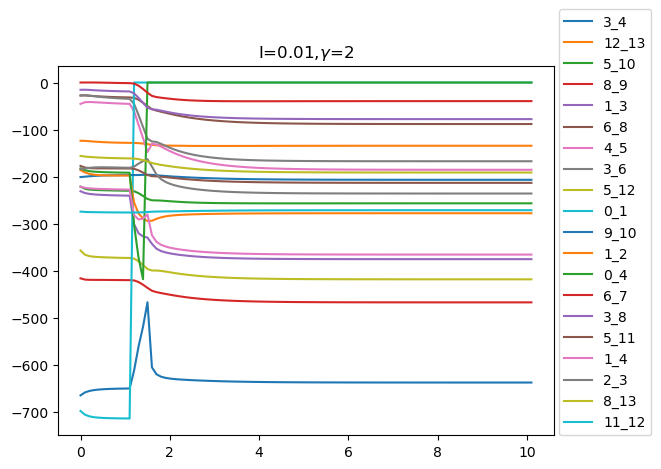

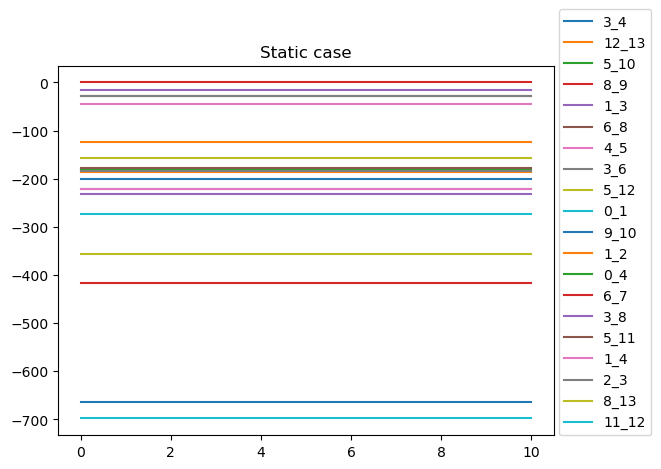

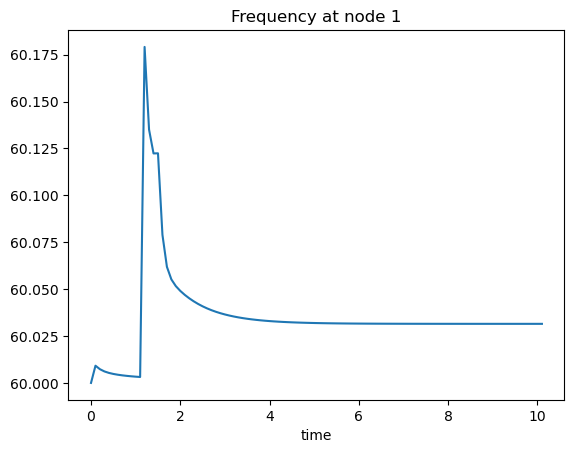

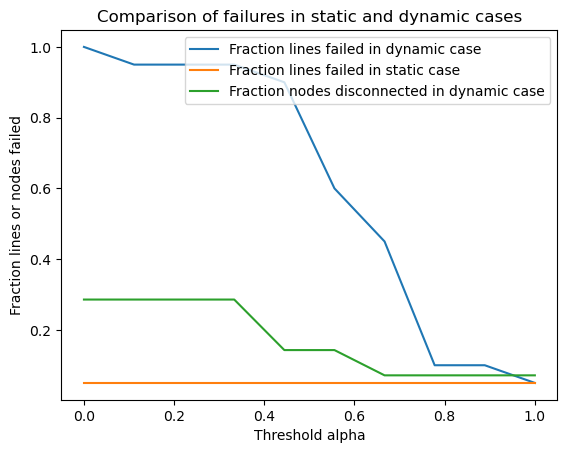

In [93]:
# impact of lower inertia across the board with resistive losses
lines_to_cut=[(0,1)]
nodes_to_cut=None
alpha=0.8
I_val = 0.01
gamma_val=2
I=np.ones(num_buses).reshape(-1,1)*I_val
H=None
gamma = np.ones(num_buses).reshape(-1,1)*gamma_val
frequency_deviation_threshold=0.6
apply_freq_dev_during_sim=False
include_resistive_losses=True
t_max=10
alpha_min=0
alpha_max=1
n_alpha=10
node_freq_plot=1
case_name="addG_lowerI_cut01_alpha0.8_I0.01_gamma2_withresist_no_freqdev"

make_plots(case_name,run_all_alphas=True)

[[0.06168779]
 [0.00485423]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]]
reached maximum N-R iterations, aborting static solve
running parallel simulation
[[0.06168779]
 [0.00485423]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]]
[[0.06168779]
 [0.00485423]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]][[0.06168779]
 [0.00485423]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]]

[[0.06168779]
 [0.00485423]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.

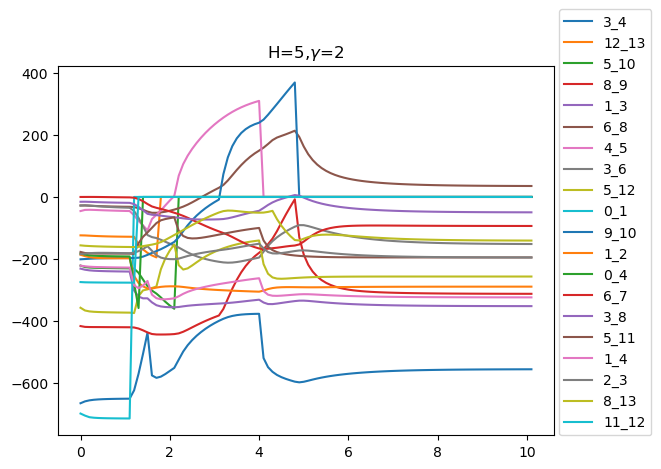

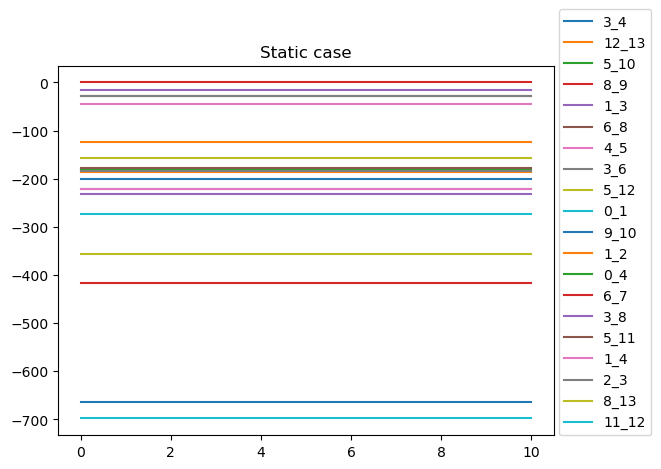

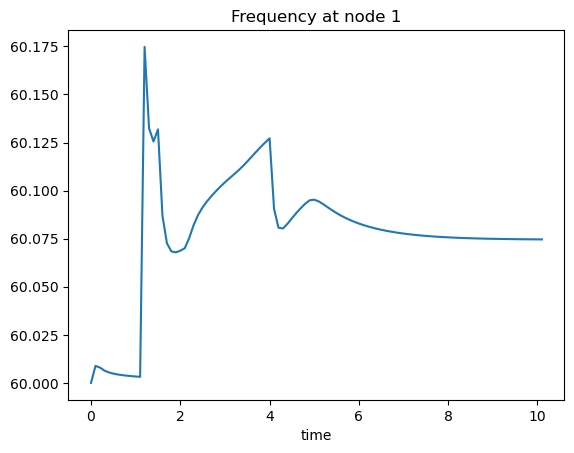

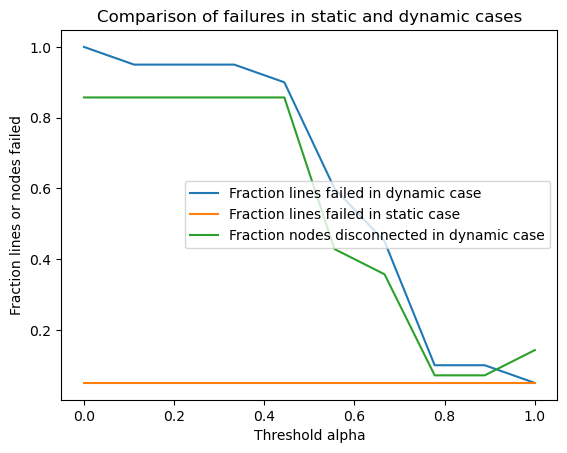

In [94]:
# (reference for) impact of adding load cutting during simulation (realistic I, resistive losses)

lines_to_cut=[(0,1)]
nodes_to_cut=None
alpha=0.7
I_val = 1
gamma_val=2
I=None#np.ones(num_buses).reshape(-1,1)*I_val
H=5
gamma = np.ones(num_buses).reshape(-1,1)*gamma_val
frequency_deviation_threshold=0.1
apply_freq_dev_during_sim=False
include_resistive_losses=True
t_max=10
alpha_min=0
alpha_max=1
n_alpha=10
node_freq_plot=1
case_name="refforloadcutting_cut01_alpha0.7_H5_gamma2_withresist_nofreqdev"

make_plots(case_name,run_all_alphas=True)

[[0.06168779]
 [0.00485423]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]]
reached maximum N-R iterations, aborting static solve
running parallel simulation
[[0.06168779]
 [0.00485423]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]]
[[0.06168779]
 [0.00485423]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]]
[[0.06168779]
 [0.00485423]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]][[0.06168779]
 [0.00485423]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.0

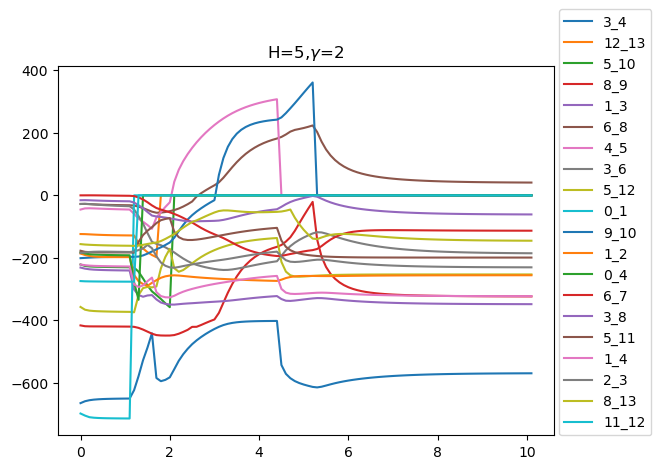

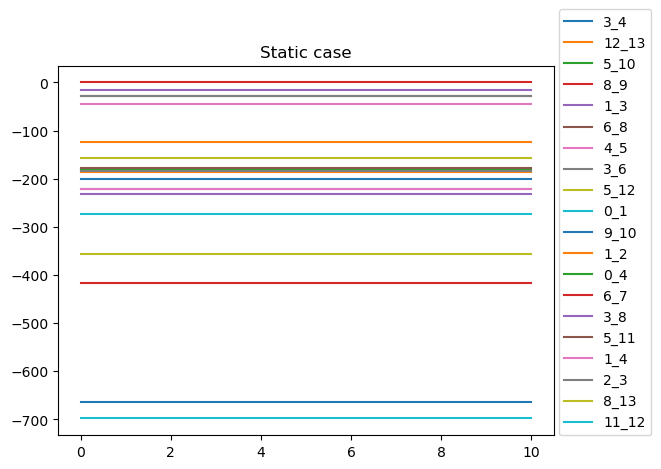

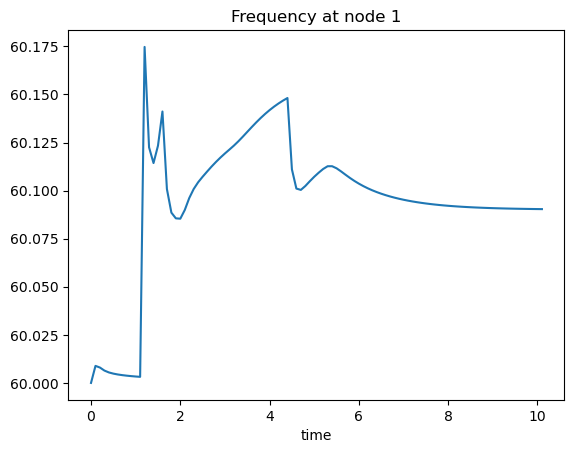

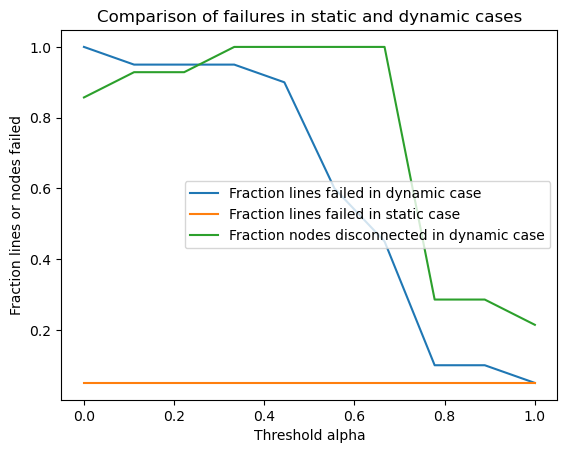

In [95]:
# impact of adding load cutting during simulation (realistic I, resistive losses)

lines_to_cut=[(0,1)]
nodes_to_cut=None
alpha=0.7
I_val = 1
gamma_val=2
I=None#np.ones(num_buses).reshape(-1,1)*I_val
H=5
gamma = np.ones(num_buses).reshape(-1,1)*gamma_val
frequency_deviation_threshold=0.1
apply_freq_dev_during_sim=True
include_resistive_losses=True
t_max=10
alpha_min=0
alpha_max=1
n_alpha=10
node_freq_plot=1
case_name="addloadcutting_cut01_alpha0.7_H5_gamma2_withresist_withfreqdev"

make_plots(case_name,run_all_alphas=True)

[[0.06168779]
 [0.00485423]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]]
running parallel simulation
[[0.06168779]
 [0.00485423]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]]
[[0.06168779]
 [0.00485423]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]][[0.06168779]
 [0.00485423]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]]

[[0.06168779]
 [0.00485423]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [0.001     ]
 [

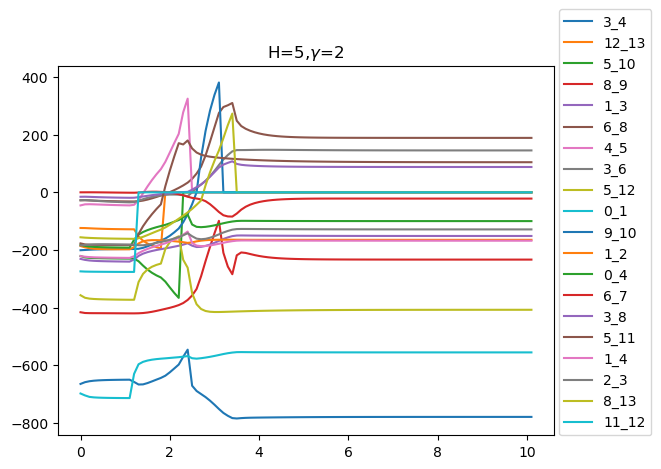

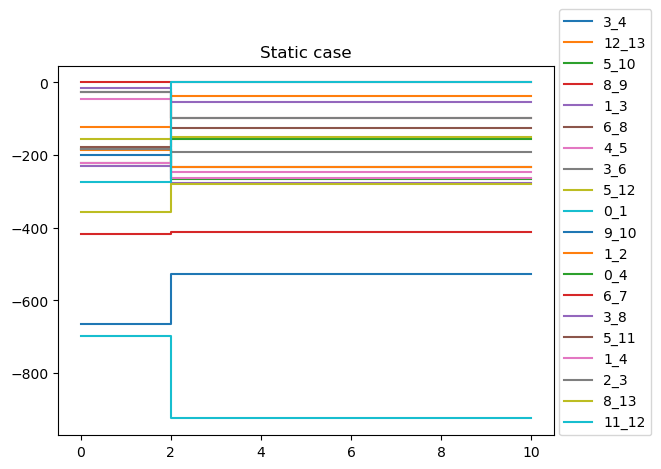

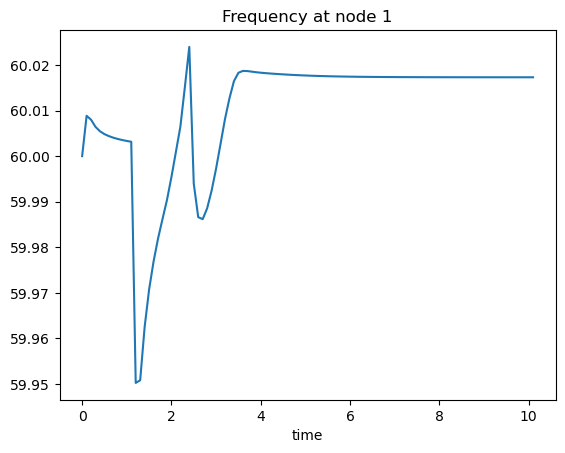

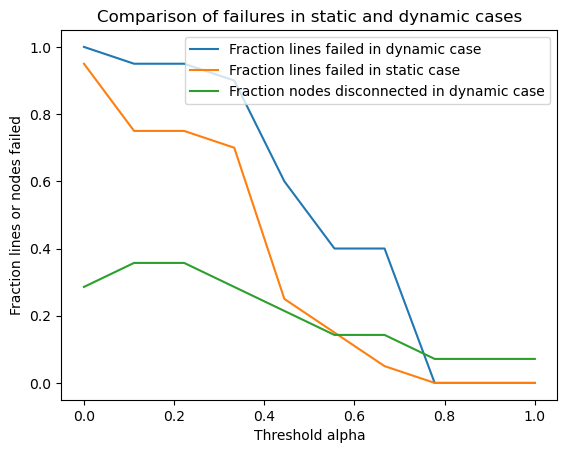

In [96]:
# impact of cutting largest generator (with load cutting, realistic I, resistive losses)

lines_to_cut=None
nodes_to_cut=[0]
alpha=0.7
I_val = 1
gamma_val=2
I=None#np.ones(num_buses).reshape(-1,1)*I_val
H=5
gamma = np.ones(num_buses).reshape(-1,1)*gamma_val
frequency_deviation_threshold=0.6
apply_freq_dev_during_sim=True
include_resistive_losses=True
t_max=10
alpha_min=0
alpha_max=1
n_alpha=10
node_freq_plot=1
case_name="gencut_cut0_alpha0.7_H5_gamma2_withresist_withfreqdev"

make_plots(case_name,run_all_alphas=True)

In [ ]:
#     results = pd.DataFrame()
#     for alpha in np.linspace(alpha_min,alpha_max,n_alpha):
#         (
#             _,_,_,_,_,_,_,_,_,fraction_lines_failed,fraction_lines_failed_static,fraction_nodes_disconnected
#         )=simulate.simulate_system(
#             Y,
#             PV_x,
#             PQ_x,
#             x_slack,
#             V_abs,
#             V_phase,
#             P_input,
#             Q_input,
#             eps,
#             max_iter,
#             base_MVA=base_mva,
#             lines_to_cut=lines_to_cut,
#             nodes_to_cut=nodes_to_cut,
#             cut_time=1,
#             delta_t=0.1,
#             alpha=alpha,
#             frequency_deviation_threshold=frequency_deviation_threshold,
#             apply_freq_dev_during_sim=apply_freq_dev_during_sim,
#             I=I,
#             H=H,
#             gamma=gamma,
#             t_max=10,
#             include_resistive_losses=include_resistive_losses,
#             ref_freq=60
#         )
#         results_alpha = pd.DataFrame(data=dict(
#             alpha=alpha,
#             fraction_lines_failed=[fraction_lines_failed],
#             fraction_lines_failed_static=[fraction_lines_failed_static],
#             fraction_nodes_disconnected=[fraction_nodes_disconnected]
#         )).set_index("alpha")
#         results = pd.concat([results,results_alpha],axis=0)